In [2]:
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

#### Загрузим данные за май.

In [156]:
table=pd.read_csv('yellow_tripdata_2016-05.csv',usecols=['tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance',
                                                       'pickup_longitude','pickup_latitude','passenger_count'])
table.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [157]:
table.tpep_pickup_datetime=pd.to_datetime(table.tpep_pickup_datetime, format='%Y-%m-%d %H:%M:%S')
table.tpep_dropoff_datetime=pd.to_datetime(table.tpep_dropoff_datetime, format='%Y-%m-%d %H:%M:%S')

#### Загрузим данные о границах регионов

In [158]:
regions=pd.read_csv('regions.csv', sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


#### Найдем уникальные значения границ по широте и долготе

In [159]:
long_borders=np.unique(np.append(regions.west.values,regions.east.values))
lat_borders=np.unique(np.append(regions.south.values,regions.north.values))

#### Фильтруем данные:

In [160]:
table.drop(table[table.tpep_dropoff_datetime==table.tpep_pickup_datetime].index, inplace=True) # нулевой длительности
table.drop(table[table.passenger_count==0].index, inplace=True) # с нулевым ко-вом пассажиров
table.drop(table[table.trip_distance==0].index, inplace=True) # с нулевым расстоянием поездки по счетчику
table.drop(table[(table.pickup_longitude < -74.25559)|(table.pickup_longitude > -73.70001)].index, inplace=True) # за границей Ньй-Йорка по долготе
table.drop(table[(table.pickup_latitude < 40.49612)|(table.pickup_latitude > 40.91553)].index, inplace=True) # за границей Ньй-Йорка по широте

#### Удаляем более ненужные колонки и заменяем колоку с датой на колонку с часом

In [161]:
table.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [162]:
del table['passenger_count']
del table['trip_distance']
del table['tpep_dropoff_datetime']
table['hour']=table.tpep_pickup_datetime.apply(lambda x: pd.datetime(x.year, x.month, x.day,x.hour))
del table['tpep_pickup_datetime']

#### Сначала определим регион для каждой поездки. Затем составим таблицу номера региона от времени.

In [163]:
regs=binned_statistic_2d(table.pickup_latitude,table.pickup_longitude,None,'count',bins=[lat_borders,long_borders]
                         , expand_binnumbers=True).binnumber

In [165]:
regs=(regs[1]-1)*50+regs[0]

In [169]:
del table['pickup_longitude']
del table['pickup_latitude']

In [168]:
table['hour_ind'] = table.hour.apply(
    lambda x : (x.day-1) *24+x.hour)
table.head()

,pickup_longitude,pickup_latitude,hour,hour_ind
0,-73.985901,40.768040,2016-05-01,0
1,-73.991577,40.744751,2016-05-01,0
2,-73.993073,40.741573,2016-05-01,0
3,-73.991943,40.684601,2016-05-01,0
4,-74.005280,40.740192,2016-05-01,0


In [173]:
binsx=np.arange(len(table.hour_ind.unique())+1)
binsy=np.arange(1,2502)
total=binned_statistic_2d( table.hour_ind,regs, None, 'count', bins=[binsx, binsy]).statistic

In [175]:
total=pd.DataFrame(total,index=np.unique(table.hour.values),columns=np.arange(1,2501))
total=total.astype(int)
total.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### По координатам Empire State Building(40.748817,-73.985428) поределим id региона.

In [92]:
reg_ESB=regions.region[(regions.east>-73.985833)&(regions.west<-73.985833)&(regions.north>40.747778)&(regions.south<40.747778)].values[0]

#### Построим график кол-ва поездок от времени

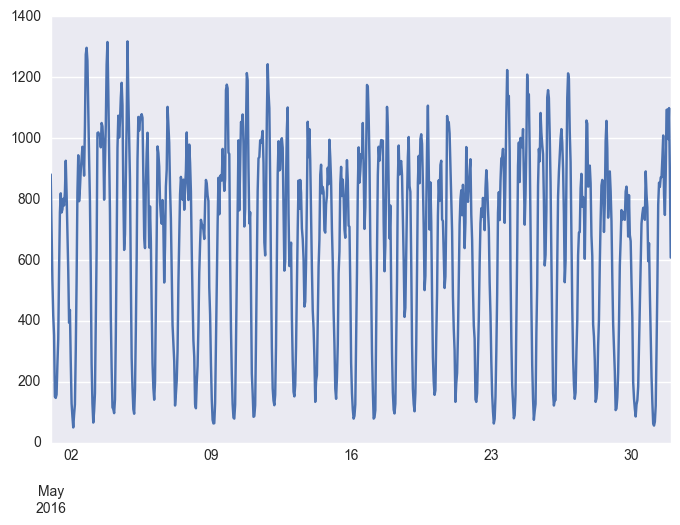

In [181]:
total[reg_ESB].plot()

#### Посчитаем количество нулевых ячеек (пар час-ячейка, для которых не было совершено ни одной поездки):

In [180]:
cnt=total.shape[0]*total.shape[1]-total.astype(bool).sum(axis=1).sum()
print('Count of zeros cells: {}'.format(cnt))

Count of zeros cells: 1718238
